Warm-up Epoch 1/100, Loss: 0.6928, Accuracy: 52.32%
Warm-up Epoch 2/100, Loss: 0.6927, Accuracy: 53.16%
Warm-up Epoch 3/100, Loss: 0.6924, Accuracy: 53.59%
Warm-up Epoch 4/100, Loss: 0.6921, Accuracy: 52.32%
Warm-up Epoch 5/100, Loss: 0.6918, Accuracy: 52.32%
Warm-up Epoch 6/100, Loss: 0.6917, Accuracy: 52.32%
Warm-up Epoch 7/100, Loss: 0.6905, Accuracy: 55.27%
Warm-up Epoch 8/100, Loss: 0.6911, Accuracy: 54.01%
Warm-up Epoch 9/100, Loss: 0.6890, Accuracy: 56.12%
Warm-up Epoch 10/100, Loss: 0.6884, Accuracy: 60.76%
Warm-up Epoch 11/100, Loss: 0.6866, Accuracy: 60.34%
Warm-up Epoch 12/100, Loss: 0.6847, Accuracy: 68.78%
Warm-up Epoch 13/100, Loss: 0.6806, Accuracy: 67.09%
Warm-up Epoch 14/100, Loss: 0.6765, Accuracy: 69.62%
Warm-up Epoch 15/100, Loss: 0.6673, Accuracy: 75.95%
Warm-up Epoch 16/100, Loss: 0.6552, Accuracy: 76.37%
Warm-up Epoch 17/100, Loss: 0.6402, Accuracy: 78.90%
Warm-up Epoch 18/100, Loss: 0.6088, Accuracy: 81.01%
Warm-up Epoch 19/100, Loss: 0.5760, Accuracy: 81.86%
Wa

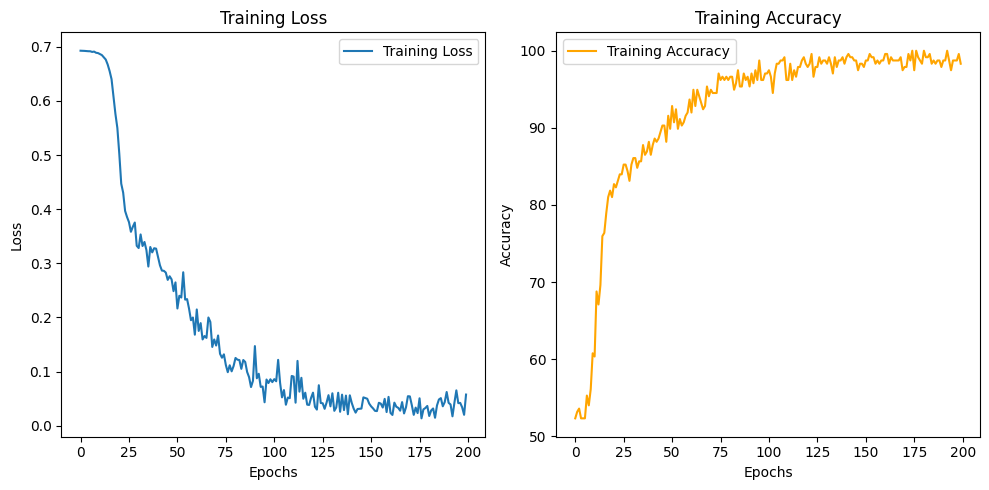

Accuracy: 0.9000
Precision: 0.8750


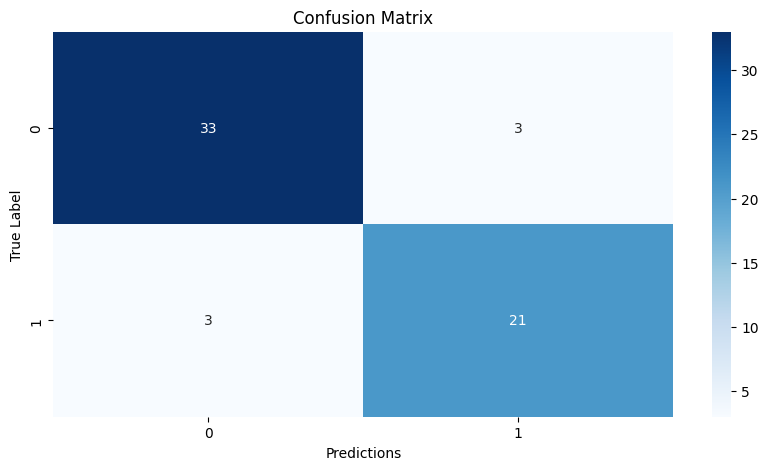

Sensitivity score:0.875
Specificity score:0.9166666666666666


In [3]:
import torch
import pandas as pd
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from ucimlrepo import fetch_ucirepo
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score,precision_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import LambdaLR, StepLR

class DataPreprocessing:
    def __init__(self):
        self.dataset = fetch_ucirepo(id=45)
        self.names = self.dataset.variables['name'][0:13]
        self.columns_names =[name for name in self.names]
    
    def __call__(self):
        self.df = pd.DataFrame(self.dataset.data.features, columns=self.columns_names)
        self.df['num'] = self.dataset.data.targets
        return self.clean_missing_value()

    def clean_missing_value(self):
        #Using mean strategy to fill the missing value may not be a good idea because the dataset is skew.
        '''imputer = SimpleImputer(strategy='mean')
        self.df = pd.DataFrame(imputer.fit_transform(self.df), columns=self.columns_names)'''

        self.df= self.df.dropna()
        return self.df 

class DataLoad:
    def __init__(self, df):
        self.x = df.drop('num', axis=1)
        self.y = df['num']
        self.scaler = StandardScaler()
        
        self.x_tensor = torch.tensor(self.scaler.fit_transform(self.x.to_numpy()), dtype=torch.float32)
        self.y_tensor = torch.tensor(self.y.to_numpy(), dtype=torch.long)

        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(
            self.x_tensor, self.y_tensor, test_size=0.2, random_state=42
        )
        self.y_train[self.y_train > 0] = 1
        self.y_test[self.y_test > 0] = 1

    def train_test(self):
        self.train_dataset = TensorDataset(self.x_train, self.y_train)
        self.test_dataset = TensorDataset(self.x_test, self.y_test)

        return self.train_dataset, self.test_dataset

    def __call__(self):
        self.train_test()
        self.train_loader = DataLoader(dataset=self.train_dataset, batch_size=32, shuffle=True)
        return self.train_loader, self.x_test, self.y_test

class HeartDiseaseModel(nn.Module):
    def __init__(self, input_size, h1, h2, h3, h4, h5):
        super(HeartDiseaseModel, self).__init__()
        self.fc1 = nn.Linear(input_size, h1)
        self.relu1 = nn.LeakyReLU()
        self.drop1 = nn.Dropout(0.1)
        self.fc2 = nn.Linear(h1, h2)
        self.relu2 = nn.LeakyReLU()
        self.drop2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(h2, h3)
        self.relu3 = nn.LeakyReLU()
        self.drop3 = nn.Dropout(0.3)
        self.fc4 = nn.Linear(h3, h4)
        self.relu4 = nn.LeakyReLU()
        self.drop4 = nn.Dropout(0.1)
        self.fc5 = nn.Linear(h4, h5)
        self.relu5 = nn.LeakyReLU()
        self.fc6 = nn.Linear(h5, 1)

    def forward(self, x):
        x = self.drop1(self.relu1(self.fc1(x)))
        x = self.drop2(self.relu2(self.fc2(x)))
        x = self.drop3(self.relu3(self.fc3(x)))
        x = self.drop4(self.relu4(self.fc4(x)))
        x = self.relu5(self.fc5(x))
        y = torch.sigmoid(self.fc6(x))
        return y

class TrainingStep:
    def __init__(self,loss_fn,optimizer,warmup_epochs,train_data,model,num_epochs):
        self.loss_fn=loss_fn
        self.optimizer=optimizer
        self.warmup_epochs=warmup_epochs
        self.train_data=train_data
        self.model=model
        self.num_epochs=num_epochs
        self.losses=[]
        self.accuracies=[]
        self.scheduler_warmup = torch.optim.lr_scheduler.LambdaLR(self.optimizer, lambda epoch: min((epoch + 1) / self.warmup_epochs, 1))
        self.training_scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=20, gamma=0.05)

    def warm_up_step(self):
        for epoch in range(self.warmup_epochs):
            self.model.train()
            epoch_loss = 0.0
            correct = 0
            total = 0
            
            for i, (x_batch, y_batch) in enumerate(self.train_data):
                self.optimizer.zero_grad()
                outputs = self.model(x_batch).squeeze()
                y_batch = y_batch.float()
                loss = self.loss_fn(outputs, y_batch)
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.item()
                predicted = (outputs > 0.5).float()
                total += y_batch.size(0)
                correct += (predicted == y_batch).sum().item()
            
            epoch_loss /= len(self.train_data)
            accuracy = 100 * correct / total
            self.losses.append(epoch_loss)
            self.accuracies.append(accuracy)
            self.scheduler_warmup.step()
            print(f"Warm-up Epoch {epoch + 1}/{self.warmup_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")

    def training_step(self):
        for epoch in range(self.warmup_epochs, self.num_epochs):
            self.model.train()
            epoch_loss = 0.0
            correct = 0
            total = 0

            for i, (x_batch, y_batch) in enumerate(self.train_data):
                self.optimizer.zero_grad()
                outputs = self.model(x_batch).squeeze()
                y_batch = y_batch.float()
                loss = self.loss_fn(outputs, y_batch)
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.item()
                predicted = (outputs > 0.5).float()
                total += y_batch.size(0)
                correct += (predicted == y_batch).sum().item()

            epoch_loss /= len(self.train_data)
            accuracy = 100 * correct / total
            self.losses.append(epoch_loss)
            self.accuracies.append(accuracy)
            self.training_scheduler.step()
            print(f"Epoch {epoch + 1}/{self.num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")
    
    def __call__(self):
        self.warm_up_step()
        self.training_step()
        
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(self.losses, label='Training Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.accuracies, label='Training Accuracy', color='orange')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Training Accuracy')
        plt.legend()
        plt.tight_layout()
        plt.show()

class Evaluation:
    def __init__(self,model,x_test,y_test):
        self.model = model
        self.x_test =x_test
        self.y_test =y_test

    def test_loop(self):
        self.model.eval()

        with torch.no_grad():
            pred = np.round(self.model(self.x_test).squeeze().cpu().numpy()).astype(int)
            accuracy = accuracy_score(self.y_test, pred)
            precision =precision_score(self.y_test, pred)

            print(f'Accuracy: {accuracy:.4f}')
            print(f'Precision: {precision:.4f}')

            matrix = confusion_matrix(self.y_test,pred)

            plt.figure(figsize=(10, 5))
            sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
            plt.xlabel('Predictions')
            plt.ylabel('True Label')
            plt.title('Confusion Matrix')
            plt.show()

            tn = matrix[0][0]
            fp = matrix[0][1]
            fn = matrix[1][0]
            tp = matrix[1][1]

            sensitivity = tp /(tp+fn)
            print(f"Sensitivity score:{sensitivity}")
            specificity = tn/(tn+fp)
            print(f"Specificity score:{specificity}")
    
def main():
    data_processor = DataPreprocessing()
    heart_disease_df = data_processor() 
    #print(heart_disease_df)

    data_load=DataLoad(heart_disease_df)
    train_data,x_test,y_test= data_load()

    input_size = 13
    h1 = 64
    h2 = 128
    h3 = 256
    h4 = 64
    h5 = 16
    warmup_epochs=100
    num_epochs = 200
    batch_size = 16
    learning_rate = 1e-3

    model = HeartDiseaseModel(input_size, h1, h2, h3, h4, h5)
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    steps=TrainingStep(loss_fn,optimizer,warmup_epochs,train_data,model,num_epochs)
    steps()

    evl=Evaluation(model,x_test,y_test)
    evl.test_loop()
    

if __name__ == "__main__":
    main()